# Qiskit Implementation of the Multi-Stage W State Distillation Protocol

We provide a comprehensive implementation of the distillation protocol, detailing each stage sequentially and concluding with the complete integrated Qiskit circuit.

# Stage 1: Amplitude-damped W states to GHZ-like states (TCED) 

This stage follows the Two-copy entanglement distillation (TCED) framework, using amplitude-damped W states as input resources. By applying local CNOT gates followed by projective measurements, this stage probabilistically produces a three-qubit GHZ-like state. In this GHZ-like state, one qubit becomes disentangled from the system, leaving the remaining two qubits in a maximally entangled Bell state. Both the GHZ-like state and the Bell pair serve as essential intermediate resources for the implementation of Stage 2.

We start by implementing the circuit for Stage 1 with just two copies, the first copy is the target copy and the second copy the sacrificial copy. So we have: 

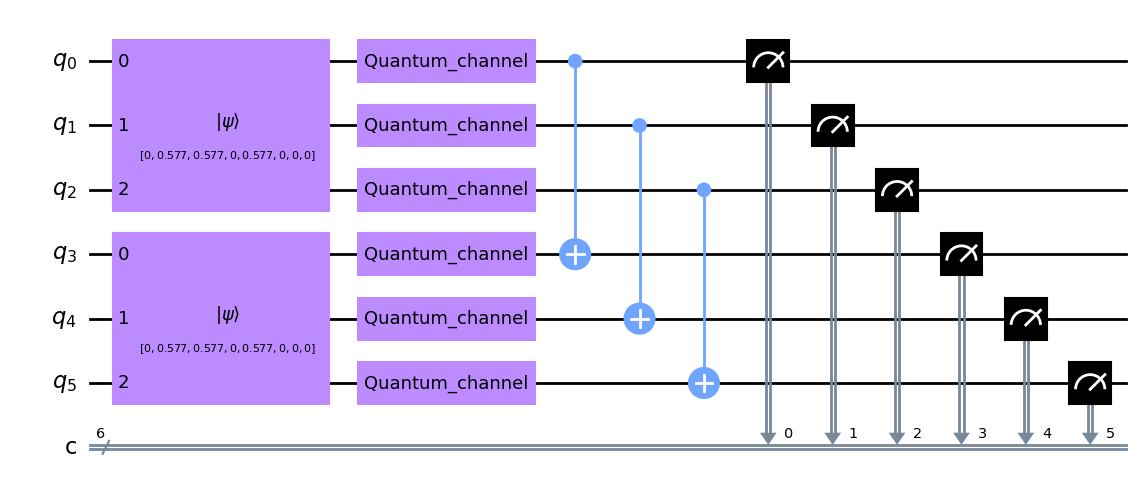

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_city
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# Parameters
# --------------------------
decay_rate = 0.5  # Amplitude damping decay rate

# --------------------------
# Quantum registers
# --------------------------
q = QuantumRegister(6, 'q')   # 6 qubits: 3 for target, 3 for sacrificial
c = ClassicalRegister(6, 'c')
qc = QuantumCircuit(q, c)

# --------------------------
# Define standard 3-qubit W state
# |W> = (1/sqrt(3)) (|100> + |010> + |001>)
# --------------------------
w_state = (1 / np.sqrt(3)) * np.array([0, 1, 1, 0, 1, 0, 0, 0])  # Qiskit ordering: |000>, |001>, ..., |111>

# Initialize two copies of |W>
qc.initialize(w_state, [0, 1, 2])  # Target copy
qc.initialize(w_state, [3, 4, 5])  # Sacrificial copy

# --------------------------
# Apply amplitude damping noise channel to all qubits
# --------------------------
amplitude_damping = amplitude_damping_error(decay_rate, excited_state_population=0, canonical_kraus=True)

for qubit in range(6):
    qc.append(amplitude_damping, [qubit])

# --------------------------
# Apply CNOT gates: target → sacrificial
# --------------------------
cnot_pairs = [(0, 3), (1, 4), (2, 5)]
for control, target in cnot_pairs:
    qc.cx(control, target)

# --------------------------
# Measurement
# Measure both target and sacrificial copies for analysis
# --------------------------
qc.measure(q, c)
qc.draw('mpl')


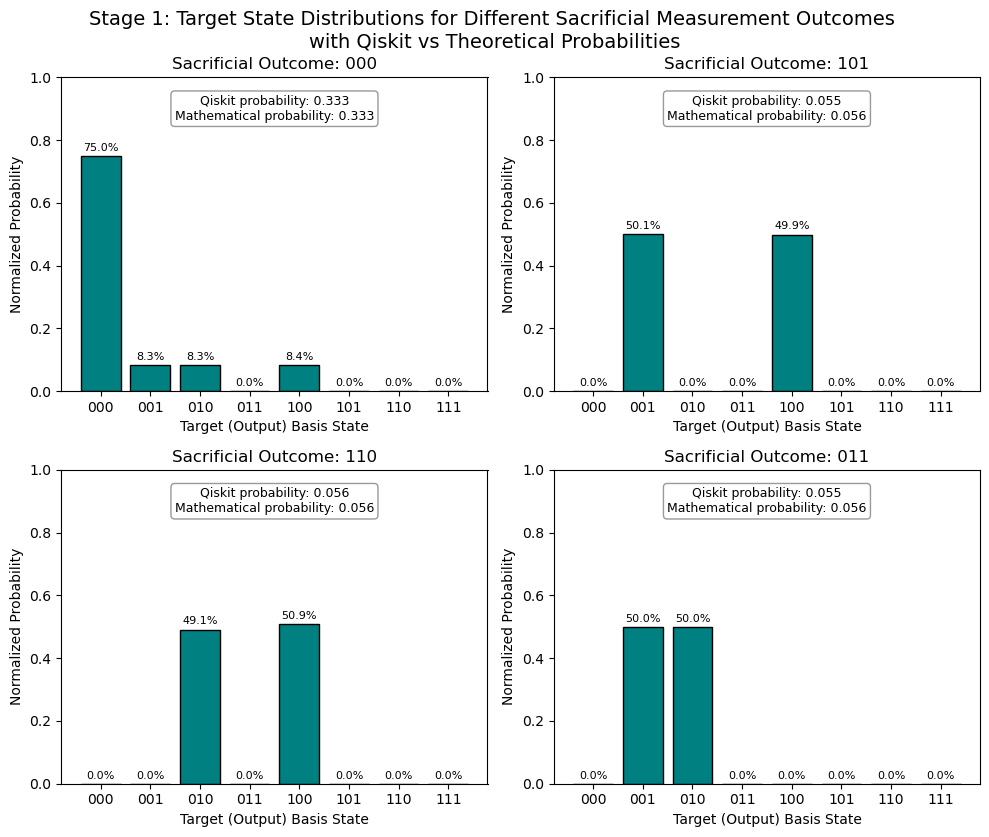

In [2]:
# running the circuit
Shots_n=100000
#qc = qc.reverse_bits()
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, shots=Shots_n)  # Run the simulation
result = job.result() 
counts = result.get_counts()  # Get the measurement counts
# ---------------------------------------------------------
# Post-processing of measurement results for specific sacrificial outcomes
# ---------------------------------------------------------
# We analyze the target (output) qubit distributions conditioned on
# specific sacrificial qubit measurement results:
#   000, 101, 110, 011
# Additionally, for each sacrificial pattern, we compute:
#   1. Qiskit success probability
#   2. Theoretical probability based on amplitude damping model
# ---------------------------------------------------------

# Define sacrificial outcomes of interest
sacrificial_patterns = ['000', '101', '110', '011']

# Initialize dictionaries
conditional_output_states = {pattern: {} for pattern in sacrificial_patterns}
sacrificial_counts = {pattern: 0 for pattern in sacrificial_patterns}

# Loop over all measurement outcomes from Qiskit
for jj, count in counts.items():
    # Split bitstring into sacrificial (first 3 bits) and target (last 3 bits)
    sacrificial_bits = jj[:3]
    target_bits = jj[3:]

    # Record counts for each sacrificial pattern of interest
    if sacrificial_bits in sacrificial_patterns:
        # Add to total counts for that sacrificial pattern
        sacrificial_counts[sacrificial_bits] += count

        # Aggregate target results for that sacrificial pattern
        conditional_output_states[sacrificial_bits][target_bits] = (
            conditional_output_states[sacrificial_bits].get(target_bits, 0) + count
        )


total_shots = sum(counts.values())
   
# ---------------------------------------------------------
# Plot conditional distributions of target (output) states
# ---------------------------------------------------------
basis_states = ['000', '001', '010', '011', '100', '101', '110', '111']
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for idx, pattern in enumerate(sacrificial_patterns):
    # Compute normalized probabilities for target qubits conditioned on sacrificial outcome
    total_counts = sum(conditional_output_states[pattern].values())
    probabilities = [conditional_output_states[pattern].get(state, 0) / total_counts
                     for state in basis_states]

    # Compute Qiskit and theoretical probabilities for labeling
    qiskit_prob = sacrificial_counts[pattern] / total_shots
    F = 1 - decay_rate
    if pattern == '000':
        math_prob = (1 - F)**2 + (F**2) / 3
    elif pattern == '101':
        math_prob = 2 * F**2 / 9
    elif pattern == '110':
        math_prob = 2 * F**2 / 9
    elif pattern == '011':
        math_prob = 2 * F**2 / 9
    else:
        math_prob = 0

    # Plot bar chart for each sacrificial outcome
    axs[idx].bar(basis_states, probabilities, color='teal', edgecolor='black')
    axs[idx].set_title(f'Sacrificial Outcome: {pattern}', fontsize=12)
    axs[idx].set_xlabel('Target (Output) Basis State', fontsize=10)
    axs[idx].set_ylabel('Normalized Probability', fontsize=10)
    axs[idx].set_ylim(0, 1)

    # Annotate each bar with probability percentage
    for i, prob in enumerate(probabilities):
        axs[idx].text(basis_states[i], prob + 0.01, f'{prob*100:.1f}%', ha='center', va='bottom', fontsize=8)

    # Add Qiskit vs Theoretical comparison on the plot
    axs[idx].text(0.5, 0.9, f'Qiskit probability: {qiskit_prob:.3f}\nMathematical probability: {math_prob:.3f}',
                  ha='center', va='center', transform=axs[idx].transAxes,
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.3'),
                  fontsize=9)

plt.tight_layout()
plt.suptitle('Stage 1: Target State Distributions for Different Sacrificial Measurement Outcomes \nwith Qiskit vs Theoretical Probabilities',
             y=1.04, fontsize=14)
plt.show()


# Stage 2: GHZ-like states to W-like states

Bell pairs and GHZ-like states from Stage 1 are used in this stage. Its purpose is to transform GHZ-like states into $W$-like states. This transformation is implemented through teleportation-based CNOT operations, which relies on pre-shared Bell states between specific parties—these Bell states are precisely the byproducts generated in Stage 1.


In this stage, a total of **four copies** of the initial noisy W state are required.  

Two of these copies are consumed (sacrificed) during Stage 1, resulting in the generation of **two GHZ-like states**.  
These distilled GHZ-like states will then be used as the **input resources** for Stage 2. 

The circuit for four copies of the amplitude-damped W state and stage 1 of the distillation protocol is as follows

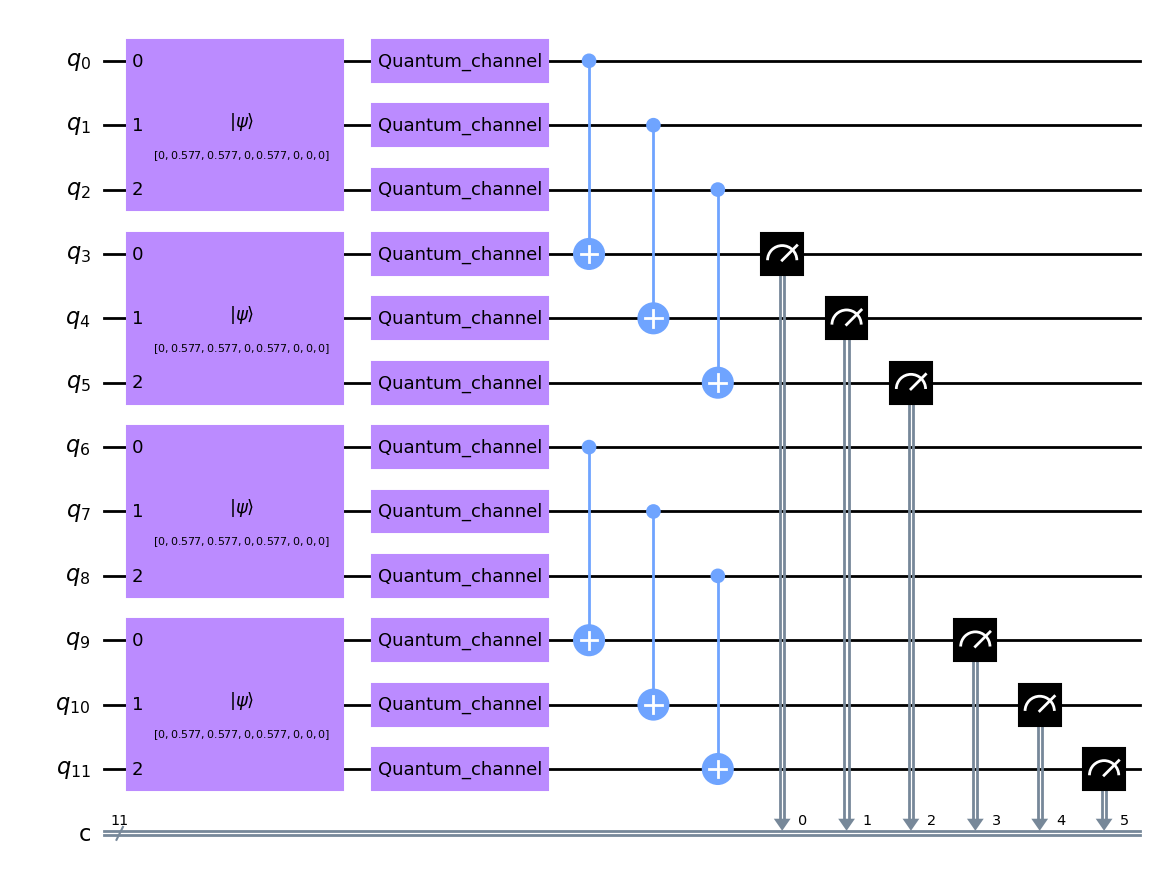

In [3]:
# --------------------------
# Quantum registers
# --------------------------
q = QuantumRegister(12, 'q')   # 12 qubits for 4 copies of W states
c = ClassicalRegister(11, 'c') # 11 classical bits for measurements
qc = QuantumCircuit(q, c)

# --------------------------
# Define standard 3-qubit W state
# |W⟩ = (1/√3)(|100⟩ + |010⟩ + |001⟩)
# --------------------------
w_state = (1 / np.sqrt(3)) * np.array([0, 1, 1, 0, 1, 0, 0, 0])  # Qiskit ordering: |000⟩ to |111⟩

# --------------------------
# Initialize four copies of W states
# --------------------------
qc.initialize(w_state, [0, 1, 2])  # Copy 1: target for Protocol 1
qc.initialize(w_state, [3, 4, 5])  # Copy 2: sacrificial for Protocol 1
qc.initialize(w_state, [6, 7, 8])  # Copy 3: target for Protocol 2
qc.initialize(w_state, [9, 10, 11]) # Copy 4: sacrificial for Protocol 2

# --------------------------
# Apply amplitude damping noise channel to all qubits
# --------------------------
amplitude_damping = amplitude_damping_error(decay_rate, excited_state_population=0, canonical_kraus=True)

for qubit in range(12):
    qc.append(amplitude_damping, [qubit])

# --------------------------
# Stage 1: Bilateral CNOT operations
# Target qubits (0,1,2) -> Sacrificial qubits (3,4,5)
# Target qubits (6,7,8) -> Sacrificial qubits (9,10,11)
# --------------------------
cnot_pairs_1 = [(0, 3), (1, 4), (2, 5)]  # First copy pair
cnot_pairs_2 = [(6, 9), (7, 10), (8, 11)] # Second copy pair

for control, target in cnot_pairs_1 + cnot_pairs_2:
    qc.cx(control, target)

# --------------------------
# Measure sacrificial qubits from Protocol 1
# Qubits 3,4,5,9,10,11 -> Classical bits 0,1,2,3,4,5
# --------------------------
sacrificial_qubits = [3, 4, 5, 9, 10, 11]
sacrificial_bits = [0, 1, 2, 3, 4, 5]
qc.measure(sacrificial_qubits, sacrificial_bits)


# --------------------------
# Display circuit diagram
# --------------------------
qc.draw('mpl')

## Stage 2 with 4 copies
Now we shuold move to the Stage 2. Below, we present the Stage 2 circuit corresponding to the output pair
$(|{\psi}_1 \rangle, |{\psi}_2 \rangle)$ of Stage 1.

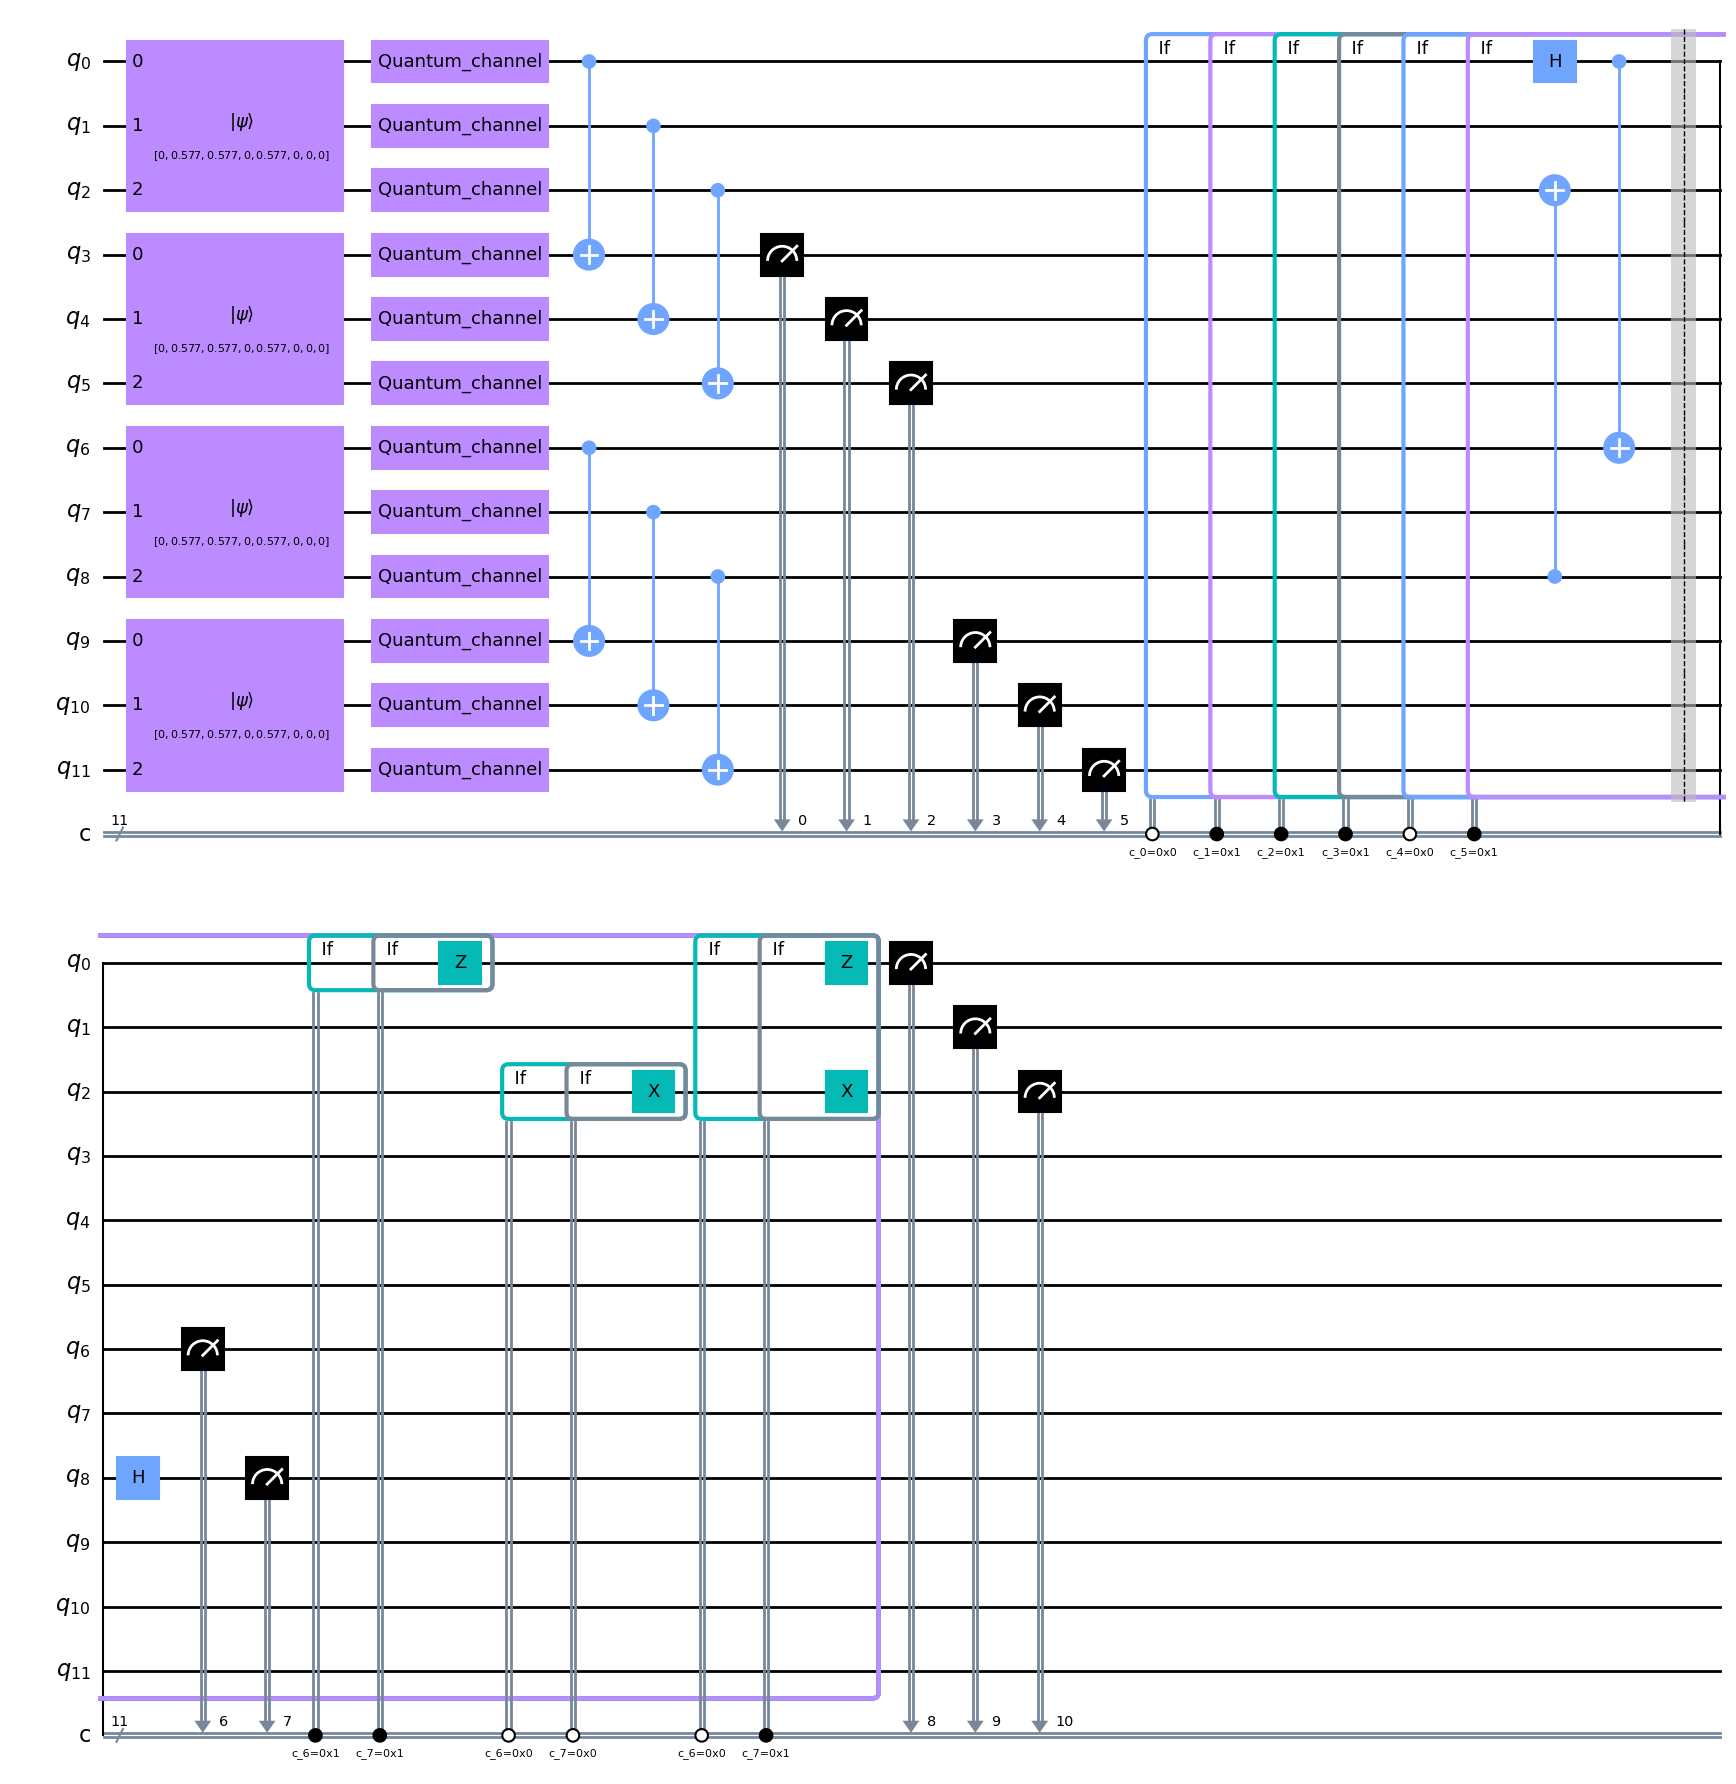

In [4]:
# --------------------------
# Stage 2: GHZ-like to W-like conversion
# Specific implementation for (|ψ⟩₁, |ψ⟩₂) outcome
# --------------------------
#(psi_1,psi_2):
with qc.if_test((0, 0)):    # Condition on measurement outcomes
    with qc.if_test((1, 1)):
        with qc.if_test((2, 1)):
            with qc.if_test((3, 1)):
                with qc.if_test((4, 0)):
                    with qc.if_test((5, 1)):                       
                        # --------------------------
                        # Hadamard and teleportation-based CNOT operations
                        # --------------------------
                        qc.h(0)                     
                        qc.cx(0, 6)  # Control: qubit 0, Target: qubit 6
                        qc.cx(8, 2)  # Control: qubit 8, Target: qubit 2                       
                        qc.barrier()
                        
                        # --------------------------
                        # Measurement and conditional corrections
                        # --------------------------
                        qc.h(8)
                        qc.measure([6, 8], [6, 7])  # Measure Bell qubits                        
                        # Z correction conditions
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 1)):
                                qc.z(0)                        
                        # X correction conditions  
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 0)):
                                qc.x(2)                        
                        # Combined X and Z correction
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 1)):
                                qc.x(2)
                                qc.z(0)

# --------------------------
# Stage 3: Final measurement of target qubits
# Qubits 0,1,2 -> Classical bits 8,9,10
# --------------------------
final_qubits = [0, 1, 2]
final_bits = [8, 9, 10]
qc.measure(final_qubits, final_bits)

# --------------------------
# Display circuit diagram
# --------------------------
qc.draw('mpl')


In [5]:
# running the circuit
Shots_n=1000000
#qc = qc.reverse_bits()
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, shots=Shots_n)  # Run the simulation
result = job.result() 
counts = result.get_counts()  # Get the measurement counts

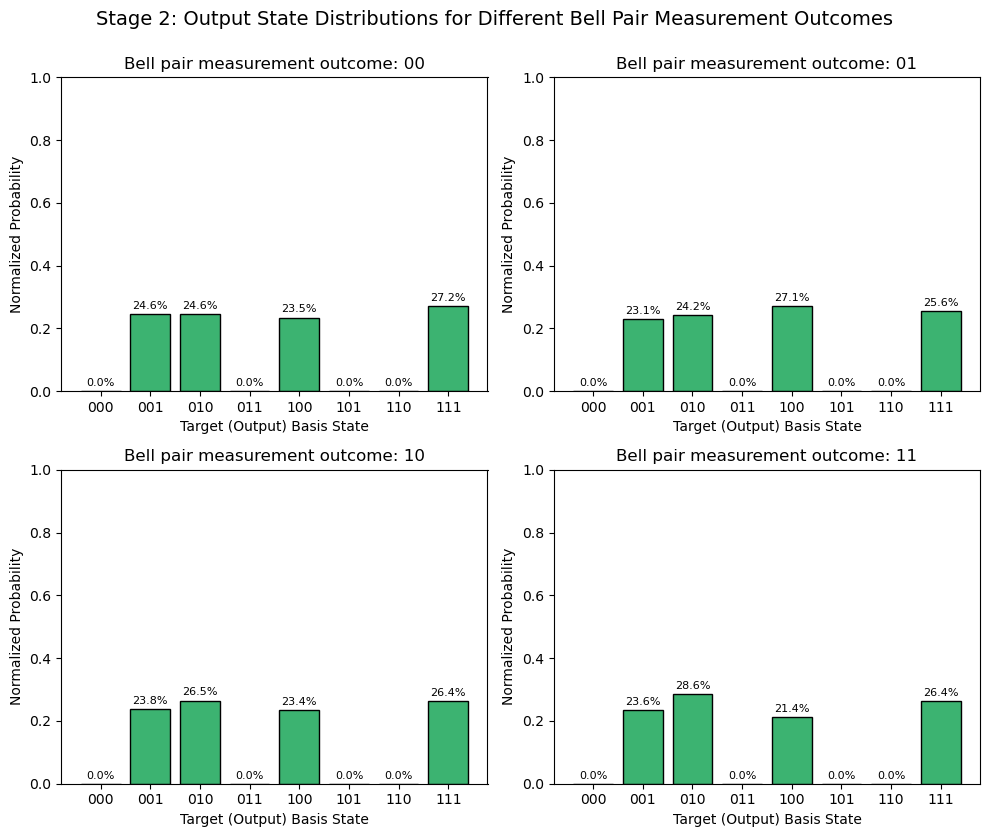

In [6]:
# ---------------------------------------------------------
# Conditional Analysis:
# There are two conditions here:
#   Condition 1: to define the specific case of output of Stage 1: (|ψ⟩₁, |ψ⟩₂)
#   Condition 2: for the Bell pair measurement result
# ---------------------------------------------------------

# Define conditional patterns of interest (Condition 2 for the Bell pair measurement result)
condition2_patterns = ['00', '01', '10', '11']

# Initialize dictionaries
conditional_Bell_states = {pattern: {} for pattern in condition2_patterns}
conditional_counts = {pattern: 0 for pattern in condition2_patterns}

# Initialize success/fail counters
success_total, fail_total = 0, 0

# Iterate over all measurement results
for jj, count in counts.items():
    # Define the specific case of output of Stage 1: (|ψ⟩₁, |ψ⟩₂)
    cond1 = (jj[-1] == '0' and jj[-2] == '1' and jj[-3] == '1' and 
             jj[-4] == '1' and jj[-5] == '0' and jj[-6] == '1')

    # for the Bell pair measurement result
    cond2_bits = jj[-8:-6]  # bits [-8] and [-7]
    
    # Proceed only if cond1 is true
    if cond1 and cond2_bits in condition2_patterns:
        success_total += count
        conditional_counts[cond2_bits] += count
        last_three = jj[:3]  # output basis (e.g., 000–111)
        conditional_Bell_states[cond2_bits][last_three] = (
            conditional_Bell_states[cond2_bits].get(last_three, 0) + count
        )
    else:
        fail_total += count

# ---------------------------------------------------------
# Compute and plot normalized distributions for different Bell measurement results
# ---------------------------------------------------------
basis_states = ['000', '001', '010', '011', '100', '101', '110', '111']
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for idx, pattern in enumerate(condition2_patterns):
    total_counts = sum(conditional_Bell_states[pattern].values())
    probabilities = [conditional_Bell_states[pattern].get(state, 0) / total_counts
                     if total_counts > 0 else 0 for state in basis_states]
    
    # Plot bar chart
    axs[idx].bar(basis_states, probabilities, color='mediumseagreen', edgecolor='black')
    axs[idx].set_title(f'Bell pair measurement outcome: {pattern}', fontsize=12)
    axs[idx].set_xlabel('Target (Output) Basis State', fontsize=10)
    axs[idx].set_ylabel('Normalized Probability', fontsize=10)
    axs[idx].set_ylim(0, 1)

    # Annotate probabilities
    for i, prob in enumerate(probabilities):
        axs[idx].text(basis_states[i], prob + 0.01, f'{prob*100:.1f}%', 
                      ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.suptitle('Stage 2: Output State Distributions for Different Bell Pair Measurement Outcomes', 
             y=1.04, fontsize=14)
plt.show()


# Stage 3: Amplitude-damped W states to maximally entangled W states by sacrificing the W-like states (TCED)

This stage performs the final distillation step within the TCED framework, yielding a maximally entangled W state. The input resources consist of two distinct states: an amplitude-damped W state the target and the W-like state from Stage 2 the sacrificial state. Local CNOT operations are applied and with the subsequent projective measurements on the sacrificial qubits yield eight possible outcomes. The outcomes 000, 011, 110, 101 herald the successful projection of the target system onto a maximally entangled W state. The remaining outcomes are discarded, constituting failure events.

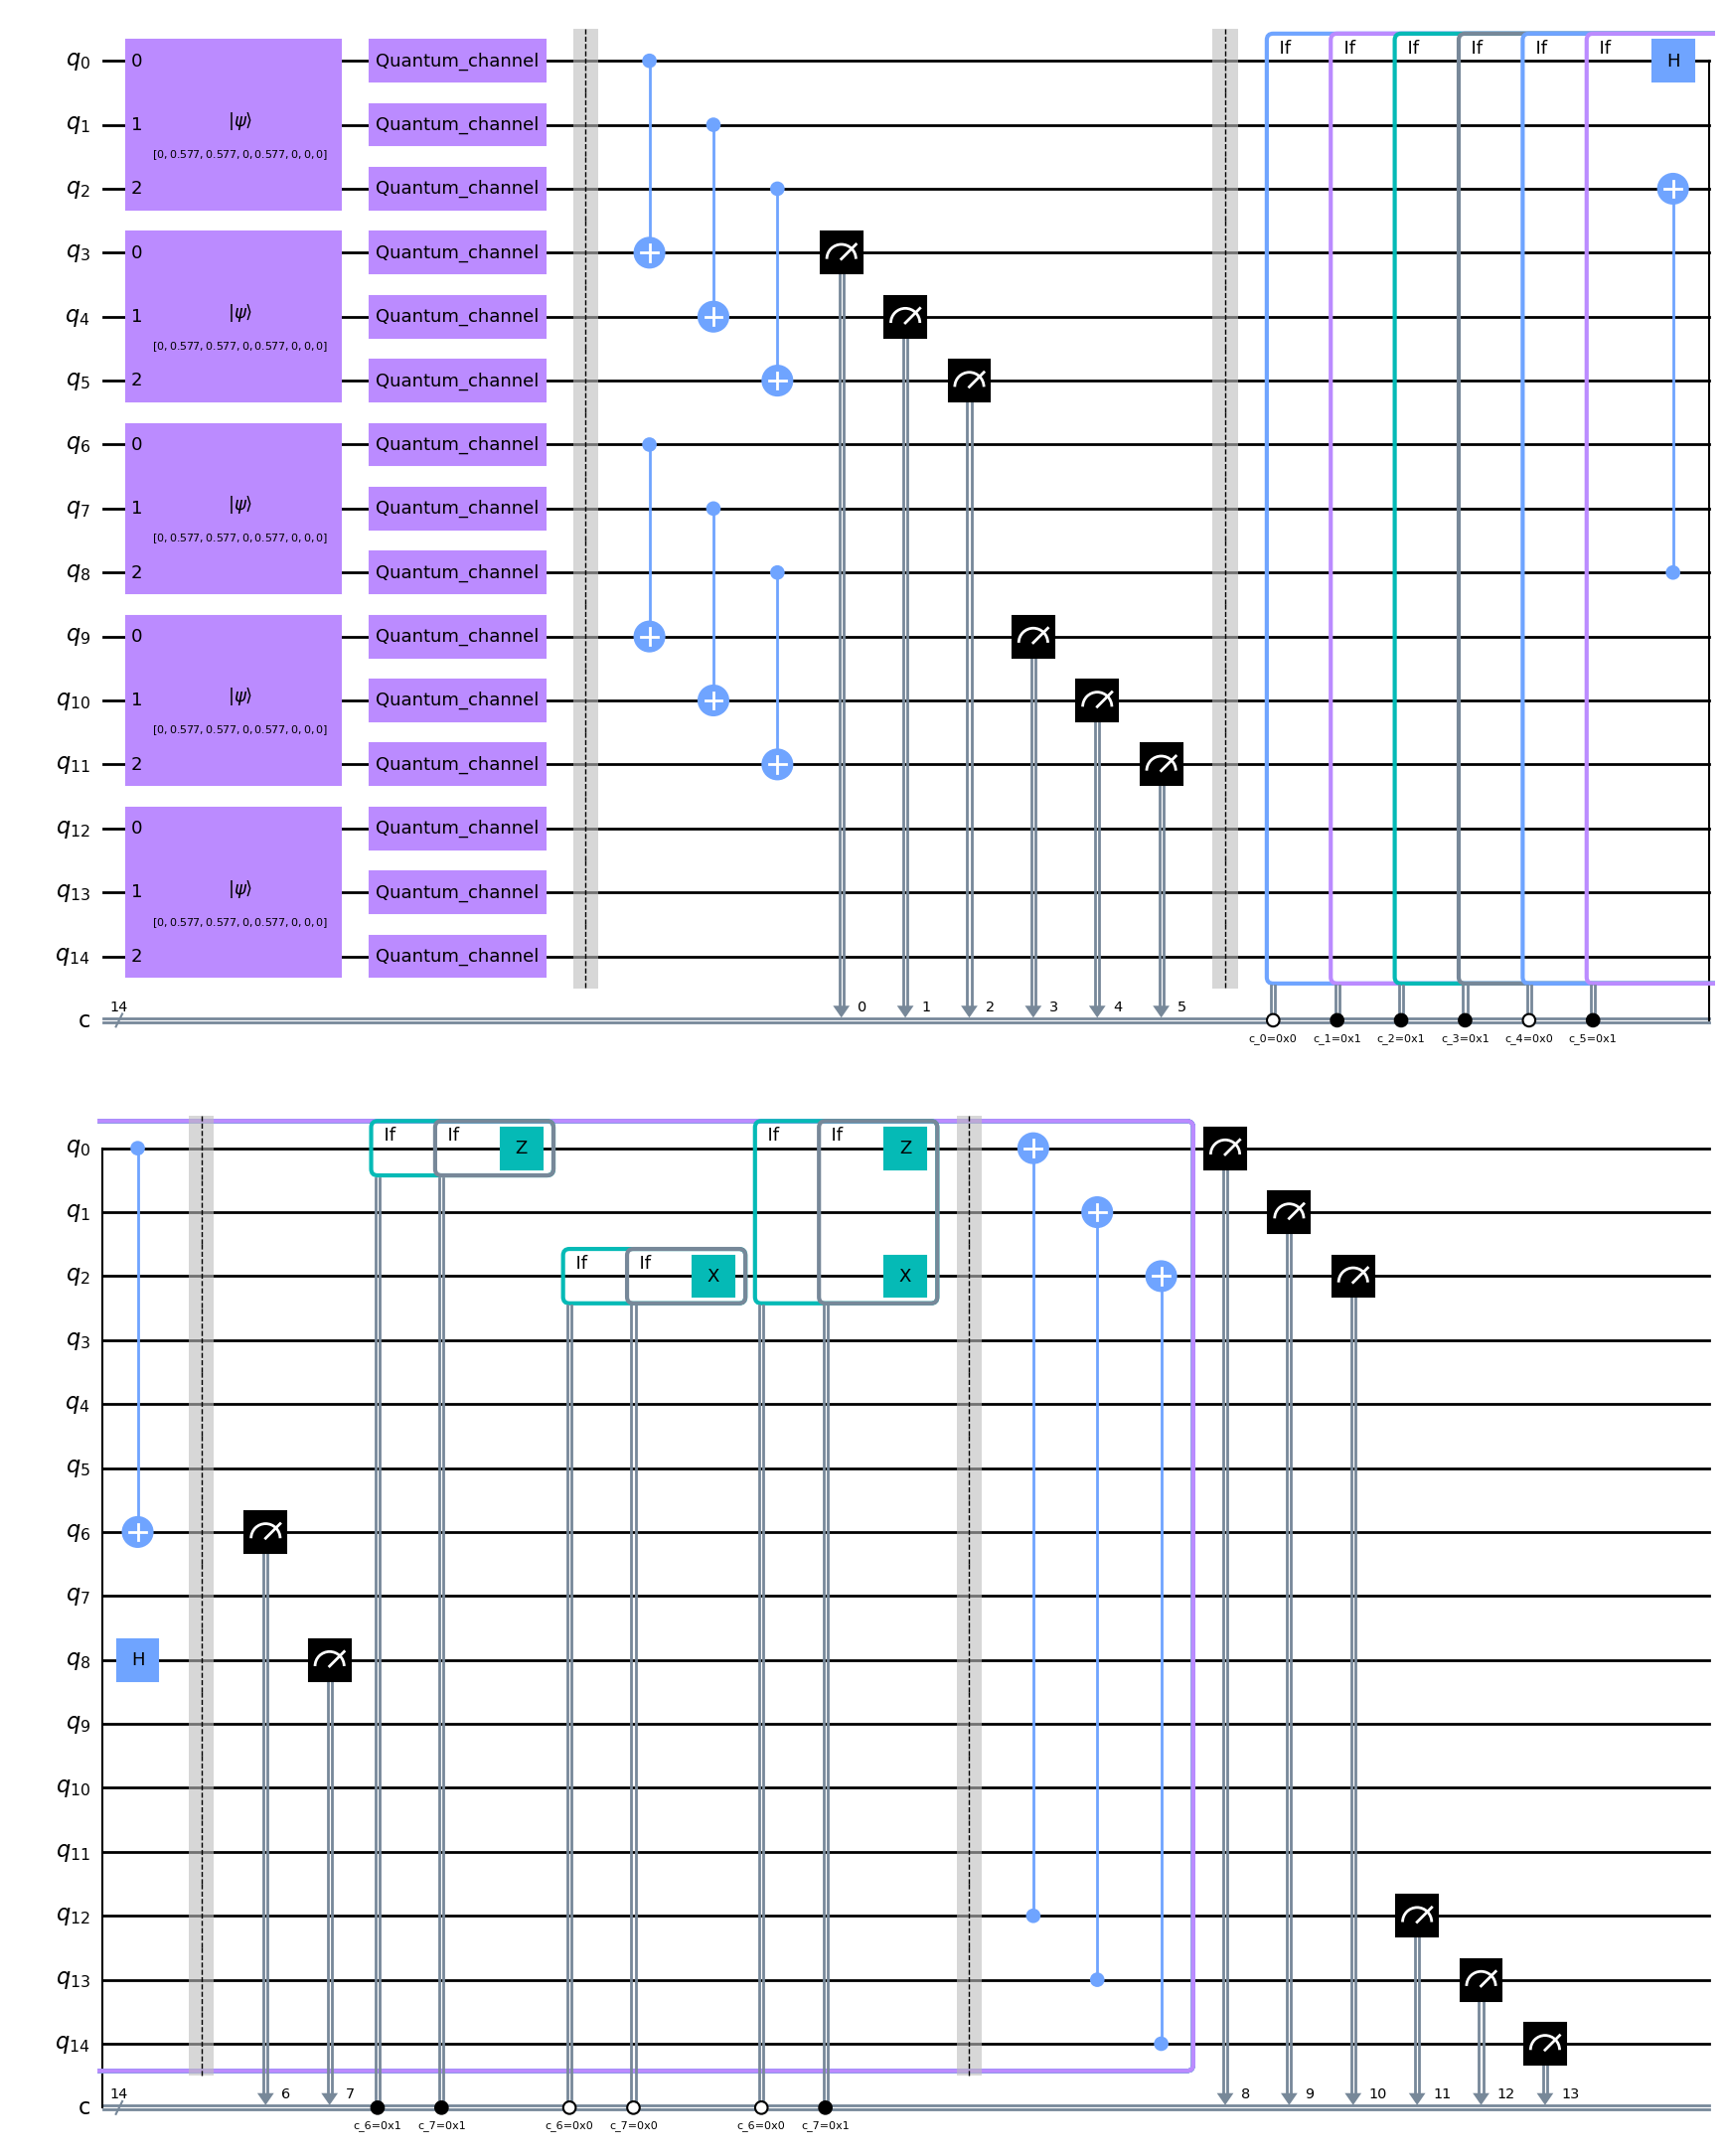

In [7]:
# ==========================================================
# Three-Stage W-State Distillation Protocol under Amplitude Damping
# ==========================================================
# This circuit implements the full entanglement distillation sequence
# for specific Stage 2 case of (|ψ₁, ψ₂⟩)
# using five amplitude-damped W-state copies (15 qubits total).
# The procedure follows three sequential stages:
#   (1) Bilateral CNOT-based purification
#   (2) GHZ-like to W-like conversion
#   (3) Final W-state extraction
# ==========================================================

# Quantum and Classical Registers
# --------------------------
# 15 qubits (five 3-qubit W-state copies)
# 11 classical bits for measurement outcomes and conditional logic
q = QuantumRegister(15, 'q')
c = ClassicalRegister(14, 'c')
qc = QuantumCircuit(q, c)

# --------------------------
# Define the standard 3-qubit W state
# |W⟩ = (1/√3)(|100⟩ + |010⟩ + |001⟩)
# --------------------------
w_state = (1 / np.sqrt(3)) * np.array([0, 1, 1, 0, 1, 0, 0, 0])  # Qiskit ordering: |000⟩ → |111⟩

# --------------------------
# Initialize five identical copies of the W state
# --------------------------
qc.initialize(w_state, [0, 1, 2])     # Copy 1
qc.initialize(w_state, [3, 4, 5])     # Copy 2
qc.initialize(w_state, [6, 7, 8])     # Copy 3
qc.initialize(w_state, [9, 10, 11])   # Copy 4
qc.initialize(w_state, [12, 13, 14])  # Copy 5

# --------------------------
# Apply amplitude damping noise channel to all qubits
# --------------------------
amplitude_damping = amplitude_damping_error(decay_rate, excited_state_population=0, canonical_kraus=True)
for qubit in range(15):
    qc.append(amplitude_damping, [qubit])

qc.barrier()

# ==========================================================
# Stage 1: Bilateral CNOT Operations 
# ----------------------------------------------------------
# - First distillation layer: target (0–2, 6–8)
#   and sacrificial copies (3–5, 9–11)
# - Perform CNOT gates and measure sacrificial qubits
# ==========================================================
qc.cx(0, 3)
qc.cx(1, 4)
qc.cx(2, 5)

qc.cx(6, 9)
qc.cx(7, 10)
qc.cx(8, 11)

# Measure sacrificial qubits
qc.measure([3, 4, 5, 9, 10, 11], [0, 1, 2, 3, 4, 5])
qc.barrier()

# ==========================================================
# Stage 2: GHZ-like to W-like Conversion
# ----------------------------------------------------------
# Conditional transformation executed for the successful
# outcome (|ψ₁, ψ₂⟩) = (0,1,1,1,0,1)
# ==========================================================
with qc.if_test((0, 0)):
    with qc.if_test((1, 1)):
        with qc.if_test((2, 1)):
            with qc.if_test((3, 1)):
                with qc.if_test((4, 0)):
                    with qc.if_test((5, 1)):
                        # --------------------------
                        # Entanglement conversion operations
                        # --------------------------
                        qc.h(0)               # Create superposition for Bell mapping
                        qc.cx(0, 6)           # Control: qubit 0 → Target: qubit 6
                        qc.cx(8, 2)           # Control: qubit 8 → Target: qubit 2
                        qc.h(8)
                        qc.barrier()

                        # --------------------------
                        # Measure intermediate Bell qubits
                        # --------------------------
                        qc.measure([6, 8], [6, 7])

                        # --------------------------
                        # Conditional corrections
                        # --------------------------
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 1)):
                                qc.z(0)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 1)):
                                qc.x(2)
                                qc.z(0)

                        qc.barrier()

                        # ==================================================
                        # Stage 3: Final W-State Extraction 
                        # --------------------------------------------------
                        # Combine the output from Stage 2 with one additional
                        # W-state copy (qubits 12–14) to extract the final state
                        # ==================================================
                        qc.cx(12, 0)
                        qc.cx(13, 1)
                        qc.cx(14, 2)

# --------------------------
# Final Measurement
# --------------------------
# Measure sacrificial qubits (0,1,2) → Classical bits (8,9,10) 
# MEasure distilled W-state qubits (12,13,14) → Classical bits (11,12,13)
# --------------------------
qc.measure([0,1,2,12,13,14],[8,9,10,11,12,13])  

# --------------------------
# Display circuit diagram
# --------------------------
qc.draw('mpl')


In [10]:
Shots_n=1000000
#qc = qc.reverse_bits()
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts

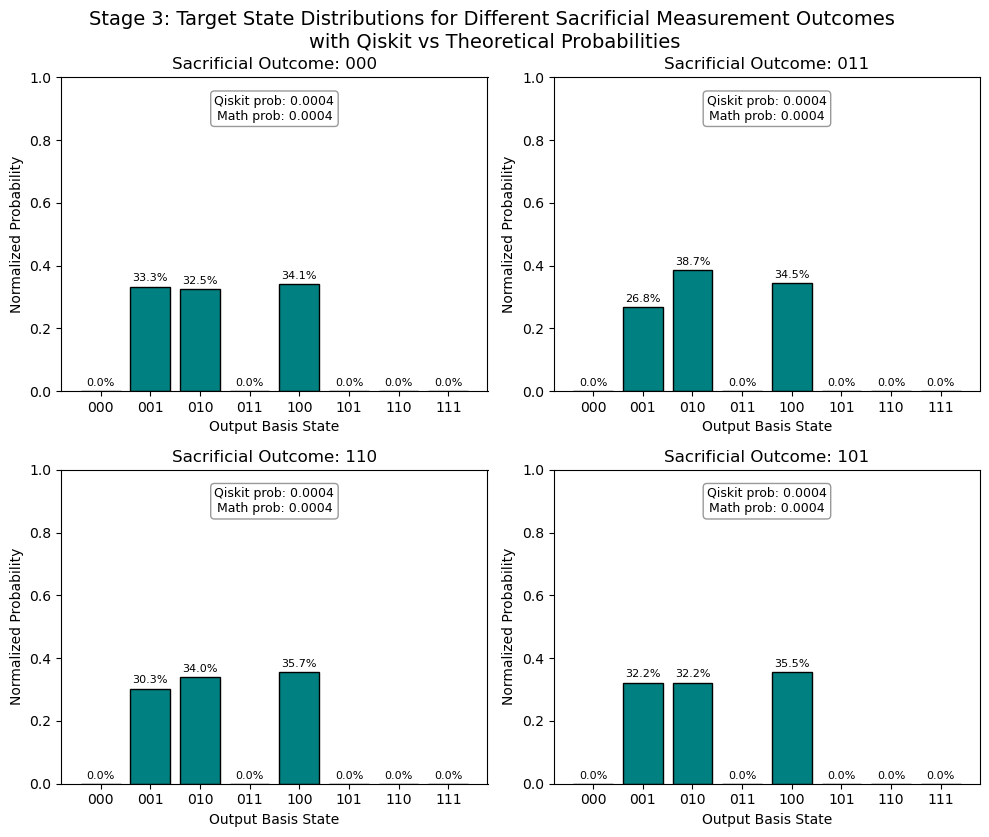

In [11]:
# ==========================================================
# Conditional Analysis: Three-Bit Condition (Stage 3)
# ==========================================================
# Analyze Bell-state (target) distributions conditioned on
# specific 3-bit patterns of the preceding qubits:
#   000, 011, 110, 101
# For each condition:
#   1. Extract measurement outcomes satisfying cond1
#   2. Condition further on the selected 3-bit pattern
#   3. Compute normalized target (output) state probabilities
# ==========================================================

# Initialize success/failure counters and dictionaries
success_total, fail_total = 0, 0
conditional_Bell_states = {}
conditional_counts = {}

# Define the four 3-bit conditional patterns of success of Stage 3
condition_patterns = ['000', '011', '110', '101']
for pattern in condition_patterns:
    conditional_Bell_states[pattern] = {}
    conditional_counts[pattern] = 0

# ----------------------------------------------------------
# Loop over all measurement outcomes in 'counts'
# ----------------------------------------------------------
for jj, count in counts.items():
    # Primary success condition (Stage 1 specific outcome (|ψ₁, ψ₂⟩))
    cond1 = (
        jj[-1] == '0' and jj[-2] == '1' and jj[-3] == '1' and
        jj[-4] == '1' and jj[-5] == '0' and jj[-6] == '1'
    )

    # Extract the relevant 3-bit segment of sacrificial qubit measurements of Stage 3
    cond_bits = jj[-11:-8]  # bits [-11], [-10], [-9]
    
    if cond1 and cond_bits in condition_patterns:
        success_total += count
        conditional_counts[cond_bits] += count

        # Extract final 3-bit target (output) state
        target_bits = jj[:3]
        conditional_Bell_states[cond_bits][target_bits] = (
            conditional_Bell_states[cond_bits].get(target_bits, 0) + count
        )
    else:
        fail_total += count

total_shots = sum(counts.values())
# ----------------------------------------------------------
# Compute normalized probabilities and visualize
# ----------------------------------------------------------
total_shots = success_total + fail_total
basis_states = ['000','001','010','011','100','101','110','111']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()


# Since mathematical probability is the same for all patterns
math_prob = (F / 4) * ((2 * F**2 / 9)**2)  # Your theoretical benchmark

for idx, pattern in enumerate(condition_patterns):
    total_counts = sum(conditional_Bell_states[pattern].values())
    probabilities = [conditional_Bell_states[pattern].get(state, 0) / total_counts
                     if total_counts > 0 else 0 for state in basis_states]

    # FIXED: Qiskit probability should be probability of this pattern occurring
    qiskit_prob = conditional_counts[pattern] / total_shots if total_shots > 0 else 0
    
    axs[idx].bar(basis_states, probabilities, color='teal', edgecolor='black')
    axs[idx].set_title(f'Sacrificial Outcome: {pattern}', fontsize=12)
    axs[idx].set_xlabel('Output Basis State', fontsize=10)
    axs[idx].set_ylabel('Normalized Probability', fontsize=10)
    axs[idx].set_ylim(0, 1)

    # Annotate probability values
    for i, prob in enumerate(probabilities):
        axs[idx].text(basis_states[i], prob + 0.01, f'{prob*100:.1f}%',
                      ha='center', va='bottom', fontsize=8)

     # Add Qiskit vs Theoretical comparison on the plot
    axs[idx].text(0.5, 0.9, f'Qiskit prob: {qiskit_prob:.4f}\nMath prob: {math_prob:.4f}',
                  ha='center', va='center', transform=axs[idx].transAxes,
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.3'),
                  fontsize=9)

plt.tight_layout()
plt.suptitle('Stage 3: Target State Distributions for Different Sacrificial Measurement Outcomes \nwith Qiskit vs Theoretical Probabilities',
             y=1.04, fontsize=14)
plt.show()



# Complete Circuit of the Proposed Distillation Protocol for All Stage 2 Cases

Thus far, we have considered only a specific case of Stage 2, namely the input pair $(|\psi_1\rangle, |\psi_2\rangle)$. We now present the complete distillation protocol for all possible input configurations in Stage 2.

The eligible input pairs for Stage 2 are: $(|\psi_1\rangle, |\psi_2\rangle)$, $(|\psi_1\rangle, |\psi_3\rangle)$, $(|\psi_2\rangle, |\psi_1\rangle)$, $(|\psi_2\rangle, |\psi_3\rangle)$, $(|\psi_3\rangle, |\psi_1\rangle)$, and $(|\psi_3\rangle, |\psi_2\rangle)$. In each case, the first element of the pair is converted into a W-like state using the second element as an auxiliary resource.

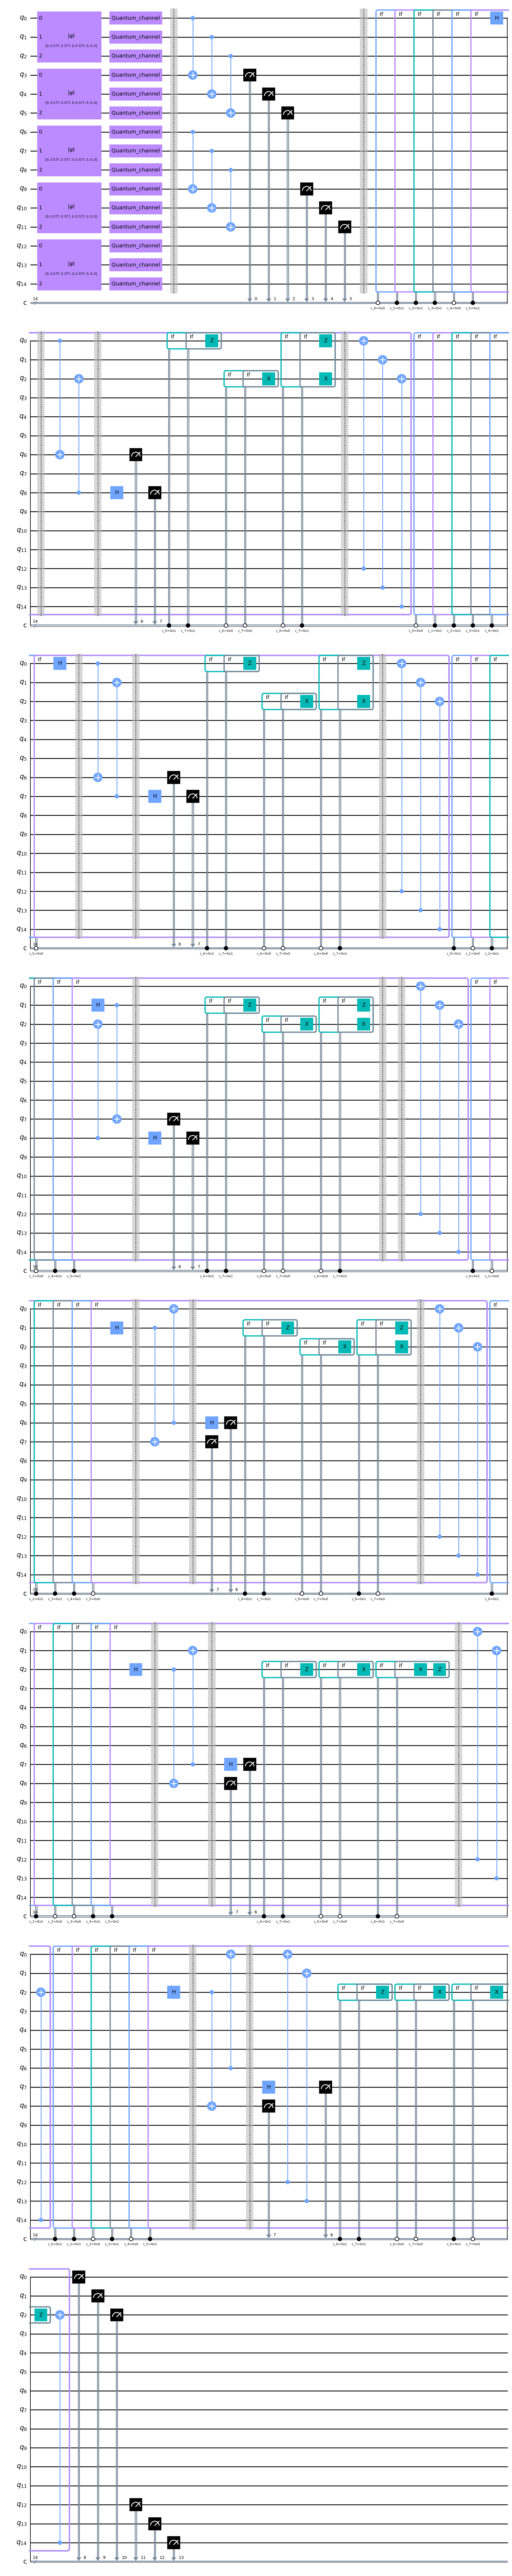

In [12]:
# ==========================================================
# Three-Stage W-State Distillation Protocol under Amplitude Damping
# ==========================================================
# This circuit implements the full entanglement distillation sequence
# using five amplitude-damped W-state copies (15 qubits total).
# The procedure follows three sequential stages:
#   (1) Bilateral CNOT-based purification
#   (2) GHZ-like to W-like conversion
#   (3) Final W-state extraction
# ==========================================================

# Quantum and Classical Registers
# --------------------------
# 15 qubits (five 3-qubit W-state copies)
# 14 classical bits for measurement outcomes and conditional logic
q = QuantumRegister(15, 'q')
c = ClassicalRegister(14, 'c')
qc = QuantumCircuit(q, c)

# --------------------------
# Define the standard 3-qubit W state
# |W⟩ = (1/√3)(|100⟩ + |010⟩ + |001⟩)
# --------------------------
w_state = (1 / np.sqrt(3)) * np.array([0, 1, 1, 0, 1, 0, 0, 0])  # Qiskit ordering: |000⟩ → |111⟩

# --------------------------
# Initialize five identical copies of the W state
# --------------------------
qc.initialize(w_state, [0, 1, 2])     # Copy 1
qc.initialize(w_state, [3, 4, 5])     # Copy 2
qc.initialize(w_state, [6, 7, 8])     # Copy 3
qc.initialize(w_state, [9, 10, 11])   # Copy 4
qc.initialize(w_state, [12, 13, 14])  # Copy 5

# --------------------------
# Apply amplitude damping noise channel to all qubits
# --------------------------
amplitude_damping = amplitude_damping_error(decay_rate, excited_state_population=0, canonical_kraus=True)
for qubit in range(15):
    qc.append(amplitude_damping, [qubit])

qc.barrier()

# ==========================================================
# Stage 1: Bilateral CNOT Operations 
# ----------------------------------------------------------
# - First distillation layer: target (0–2, 6–8)
#   and sacrificial copies (3–5, 9–11)
# - Perform CNOT gates and measure sacrificial qubits
# ==========================================================
qc.cx(0, 3)
qc.cx(1, 4)
qc.cx(2, 5)

qc.cx(6, 9)
qc.cx(7, 10)
qc.cx(8, 11)

# Measure sacrificial qubits
qc.measure([3, 4, 5, 9, 10, 11], [0, 1, 2, 3, 4, 5])
qc.barrier()

# ==========================================================
# Stage 2: GHZ-like to W-like Conversion for all eligible input states 

# ==========================================================
#(\psi_1,\psi_2)
with qc.if_test((0, 0)):
    with qc.if_test((1, 1)):
        with qc.if_test((2, 1)):
            with qc.if_test((3, 1)):
                with qc.if_test((4, 0)):
                    with qc.if_test((5, 1)):
                        qc.h(0)
                        #qc.cx(0,2)
                        qc.barrier()
                        qc.cx(0, 6) # 1-> B1
                        qc.cx(8, 2) # 3-> B3
                        qc.barrier()
                        qc.h(8)
                        qc.measure([6,8],[6,7])  
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 1)):
                                qc.z(0)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 1)):
                                qc.x(2)
                                qc.z(0)
                        qc.barrier()
                        qc.cx(12, 0)
                        qc.cx(13, 1)
                        qc.cx(14, 2)

#(\psi_1,\psi_3) 
with qc.if_test((0, 0)):
    with qc.if_test((1, 1)):
        with qc.if_test((2, 1)):
            with qc.if_test((3, 1)):
                with qc.if_test((4, 1)):
                    with qc.if_test((5, 0)):
                        qc.h(0)
                        #qc.cx(0,1)
                        qc.barrier()
                        qc.cx(0, 6) # 1-> B1
                        qc.cx(7, 1) # B2-> 2
                        qc.barrier()
                        qc.h(7)
                        qc.measure([6,7],[6,7])  
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 1)):
                                qc.z(0)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 1)):
                                qc.x(2)
                                qc.z(0)
                        qc.barrier()
                        qc.cx(12, 0)
                        qc.cx(13, 1)
                        qc.cx(14, 2)                           
                                        
#(\psi_2,\psi_1)                        
with qc.if_test((0, 1)):
    with qc.if_test((1, 0)):
        with qc.if_test((2, 1)):
            with qc.if_test((3, 0)):
                with qc.if_test((4, 1)):
                    with qc.if_test((5, 1)):
                        qc.h(1)
                        #qc.cx(1,2)
                        qc.cx(1, 7) # 2-> B2
                        qc.cx(8, 2) # B3-> 3
                        qc.barrier()
                        qc.h(8)
                        qc.measure([7,8],[6,7])  
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 1)):
                                qc.z(1)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 1)):
                                qc.x(2)
                                qc.z(1)
                        qc.barrier()
                        qc.barrier()                        
                        qc.cx(12, 0)
                        qc.cx(13, 1)
                        qc.cx(14, 2)                        

#(\psi_2,\psi_3)
with qc.if_test((0, 1)):
    with qc.if_test((1, 0)):
        with qc.if_test((2, 1)):
            with qc.if_test((3, 1)):
                with qc.if_test((4, 1)):
                    with qc.if_test((5, 0)):
                        qc.h(1)
                        qc.barrier()
                        qc.cx(1, 7) # 2-> B2
                        qc.cx(6, 0) # B1-> 1
                        qc.barrier()
                        qc.h(6)
                        qc.measure([6,7],[6,7])  
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 1)):
                                qc.z(1)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                                qc.z(1)                            
                        qc.barrier()
                        qc.cx(12, 0)
                        qc.cx(13, 1)
                        qc.cx(14, 2)                               
                        
                        
#(\psi_3,\psi_1) 
with qc.if_test((0, 1)):
    with qc.if_test((1, 1)):
        with qc.if_test((2, 0)):
            with qc.if_test((3, 0)):
                with qc.if_test((4, 1)):
                    with qc.if_test((5, 1)):
                        qc.h(2)
                        #qc.cx(2,1)
                        qc.barrier()
                        qc.cx(2, 8) # 3-> B3
                        qc.cx(7, 1) # B2-> 2
                        qc.barrier()
                        qc.h(7)
                        qc.measure([7,8],[6,7])  
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 1)):
                                qc.z(2)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                                qc.z(2)
                        qc.barrier()
                        qc.cx(12, 0)
                        qc.cx(13, 1)
                        qc.cx(14, 2)                          
                        
#(\psi_3,\psi_2)
with qc.if_test((0, 1)):
    with qc.if_test((1, 1)):
        with qc.if_test((2, 0)):
            with qc.if_test((3, 1)):
                with qc.if_test((4, 0)):
                    with qc.if_test((5, 1)):
                        qc.h(2)
                        #qc.cx(2,0)
                        qc.barrier()
                        qc.cx(2, 8) # 3-> B3
                        qc.cx(6, 0) # B1-> 1
                        qc.barrier()
                        qc.h(7)
                        qc.measure([7,8],[6,7])  
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 1)):
                                qc.z(2)
                        with qc.if_test((6, 0)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                        with qc.if_test((6, 1)):
                            with qc.if_test((7, 0)):
                                qc.x(2)
                                qc.z(2)
                        qc.cx(12, 0)
                        qc.cx(13, 1)
                        qc.cx(14, 2)   
      

    
# --------------------------
# Final Measurement
# --------------------------
# Measure sacrificial qubits (0,1,2) → Classical bits (8,9,10) 
# MEasure distilled W-state qubits (12,13,14) → Classical bits (11,12,13)
# --------------------------
qc.measure([0,1,2,12,13,14],[8,9,10,11,12,13])  

# --------------------------
# Display circuit diagram
# --------------------------
qc.draw('mpl')


In [13]:
Shots_n=10000
#qc = qc.reverse_bits()
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
#print(counts)

Qiskit Success Probability : 0.0096
Theoretical Probability : 0.009259259259259259


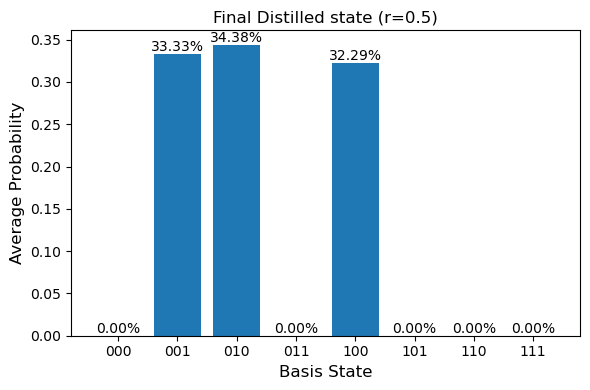

In [16]:
# ---------------------------------------------------------
# Post-Processing of Quantum Measurement Results
# ---------------------------------------------------------
# This section analyzes the measurement outcomes (counts) obtained
# from executing the circuit. It identifies successful W-state
# projections based on specific measurement patterns (cond1, cond2),
# cond1 for successful outcomes of Stage 1 and 
# cond2 for successful outcomes of Stage 3  
# ---------------------------------------------------------

success, fail = 0, 0
Bell_states = {}
Bell_new = {}

# ---------------------------------------------------------
# Filter measurement results by matching success conditions
# ---------------------------------------------------------
for jj in counts:
    # -----------------------------------------------------
    # Condition 1: Identify valid (ψ_i, ψ_j) Bell patterns
    #   Each case corresponds to a specific qubit interaction
    #   configuration based on the last 6 measured bits.
    # -----------------------------------------------------
    cond1 = (
        # (ψ₁, ψ₂)
        (jj[-1]=='0' and jj[-2]=='1' and jj[-3]=='1' and jj[-4]=='1' and jj[-5]=='0' and jj[-6]=='1')
        or
        # (ψ₁, ψ₃)
        (jj[-1]=='0' and jj[-2]=='1' and jj[-3]=='1' and jj[-4]=='1' and jj[-5]=='1' and jj[-6]=='0')
        or
        # (ψ₂, ψ₁)
        (jj[-1]=='1' and jj[-2]=='0' and jj[-3]=='1' and jj[-4]=='0' and jj[-5]=='1' and jj[-6]=='1')
        or
        # (ψ₂, ψ₃)
        (jj[-1]=='1' and jj[-2]=='0' and jj[-3]=='1' and jj[-4]=='1' and jj[-5]=='1' and jj[-6]=='0')
        or
        # (ψ₃, ψ₁)
        (jj[-1]=='1' and jj[-2]=='1' and jj[-3]=='0' and jj[-4]=='0' and jj[-5]=='1' and jj[-6]=='1')
        or
        # (ψ₃, ψ₂)
        (jj[-1]=='1' and jj[-2]=='1' and jj[-3]=='0' and jj[-4]=='1' and jj[-5]=='0' and jj[-6]=='1')
    )

    # -----------------------------------------------------
    # Condition 2: Target-state grouping based on bits [-9:-11]
    #   This part recognize the success of Stage 3 
    #   000, 011, 101, 110 — used to check correlated outcomes.
    # -----------------------------------------------------
    cond2 = (
        (jj[-9]=='0' and jj[-10]=='0' and jj[-11]=='0')  
        or
        (jj[-9]=='0' and jj[-10]=='1' and jj[-11]=='1')  
        or
        (jj[-9]=='1' and jj[-10]=='1' and jj[-11]=='0')  
        or
        (jj[-9]=='1' and jj[-10]=='0' and jj[-11]=='1') 
    )

    # -----------------------------------------------------
    # Success case: both conditions satisfied, Success of both Stage 1 and Stage 3
    # -----------------------------------------------------
    if cond1 and cond2:
        success += counts[jj]
        Bell_state = jj
        Bell_states[Bell_state] = Bell_states.get(Bell_state, 0) + counts[jj]
    else:
        fail += counts[jj]

# ---------------------------------------------------------
# Aggregate success and failure counts
# ---------------------------------------------------------
total = success + fail

# ---------------------------------------------------------
# Extract 3-bit logical states (Distilled W state)
# ---------------------------------------------------------
for i in Bell_states:
    last_char = i[:3]
    Bell_new[last_char] = Bell_new.get(last_char, 0) + Bell_states[i]

# ---------------------------------------------------------
# Compute success probability and theoretical prediction
# ---------------------------------------------------------

print("Qiskit Success Probability :", (success / total))

Math_prob_tot = ((24 * F**5) / 81)
print("Theoretical Probability :", Math_prob_tot)

# ---------------------------------------------------------
# Visualization: Normalized Bell state probabilities
# ---------------------------------------------------------
basis_states = ['000','001','010','011','100','101','110','111']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states]

plt.figure(figsize=(6,4))
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State', fontsize=12)
plt.ylabel('Average Probability', fontsize=12)
plt.title(f'Final Distilled state (r={decay_rate})', fontsize=12)

# Annotate bars with percentage values
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


The experimental simulation results, as visualized in the preceding plot, provide conclusive evidence that the final distilled state is a maximally entangled W state. This outcome directly fulfills the theoretical promise of our protocol, demonstrating that the specific sequence of operations in the three-stage process successfully counteracts the effects of amplitude damping. 